# Capstone: Sephora. Predicting prices based on Ingredients

## Problem description

It is an assumption customers make that their skin care product price is dependent on the ingredients in this product. The goal of my projects is to see if I can predict prices of the products based on the ingredients. To accomplish this goal, I first had to gather my data. I used Sephora.com data for this.

### Project Structure:
- Notebook 0. Selenium URL Collection
- Notebook 1. Saving data from URL to an HTML file
- Notebook 2. Collecting Product Data
- Notebook 3. Data Cleaning 
- Notebook 4. EDA
- Notebook 5. Fuzzy String Matching
- Notebook 6. Regression Modeling
- Notebook 7. Classification Modeling

To see if I could achieve better results with a classification problem than I did with regression, I broke the price per ounce in to categories. When picking categories I was going off my experince working as an esthetician and working with clients. I went off the common perception of cheap, moderate and expensive that I gathered from client's reactions during my work. You can see above that my results weren't much better than with regression. One thing to note is that my models were much better at predicting cheap and expensive than the middle two categories. This most likely is a consequence of having unbalanced classes. 

In [1]:
#pip install mlxtend

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector

In [3]:
products = pd.read_csv('./data/products_fuzzywuzzy.csv')
products.head(2)

,name,brand,category,price,ingredients,no_reviews,hearts,size1,size2,url,final_size,price_per_ounce
0,Protini™ Polypeptide Moisturizer,Drunk Elephant,moisturizing-cream-oils-mists,68.0,"Dicaprylyl Carbonate, Glycerin, Cetearyl Alcoh...",3000,216935,1.69,0.0,https://www.sephora.com/product/protini-tm-pol...,1.69,40.236686
1,The Water Cream,Tatcha,moisturizing-cream-oils-mists,68.0,"Dicaprylyl Carbonate, Glycerin, Cetearyl Alcoh...",2000,197492,0.00,1.7,https://www.sephora.com/product/the-water-crea...,1.70,40.000000


In [4]:
#creating a classification varible 'class' to use as our y variable
for i in products.index:
    if products.loc[i, 'price_per_ounce'] < 25:
        products.loc[i, 'class'] = 0
    elif ((products.loc[i, 'price_per_ounce'] >= 25) & (products.loc[i, 'price_per_ounce'] < 50)):
        products.loc[i, 'class'] = 1
    elif ((products.loc[i, 'price_per_ounce'] >= 50) & (products.loc[i, 'price_per_ounce'] < 100)):
        products.loc[i, 'class'] = 2
    else:
        products.loc[i, 'class'] = 3
        
products['class'] = products['class'].astype(int)
products.head(2)

,name,brand,category,price,ingredients,no_reviews,hearts,size1,size2,url,final_size,price_per_ounce,class
0,Protini™ Polypeptide Moisturizer,Drunk Elephant,moisturizing-cream-oils-mists,68.0,"Dicaprylyl Carbonate, Glycerin, Cetearyl Alcoh...",3000,216935,1.69,0.0,https://www.sephora.com/product/protini-tm-pol...,1.69,40.236686,1
1,The Water Cream,Tatcha,moisturizing-cream-oils-mists,68.0,"Dicaprylyl Carbonate, Glycerin, Cetearyl Alcoh...",2000,197492,0.00,1.7,https://www.sephora.com/product/the-water-crea...,1.70,40.000000,1


In [5]:
#baseline
products['class'].value_counts(normalize = True)

0    0.445258
1    0.225885
2    0.186813
3    0.142043
Name: class, dtype: float64

In [6]:
#https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification

def plot_multiclass_roc(clf, X_test_cvec, y_test, model, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test_cvec)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve for Sephora Classification {} Model'.format(model), weight = 'bold')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

## Raw Modeling

In [7]:
X = products['ingredients'] #setting our X variable

y = products['class'] #our y variable is price_per_ounce

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33, stratify = y)

In [8]:
#CountVactorizer splits the ingredients by comma and not in to individual words
cvec = CountVectorizer(tokenizer=lambda x: x.split(', '))
#training CountVectorizer and transforming
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

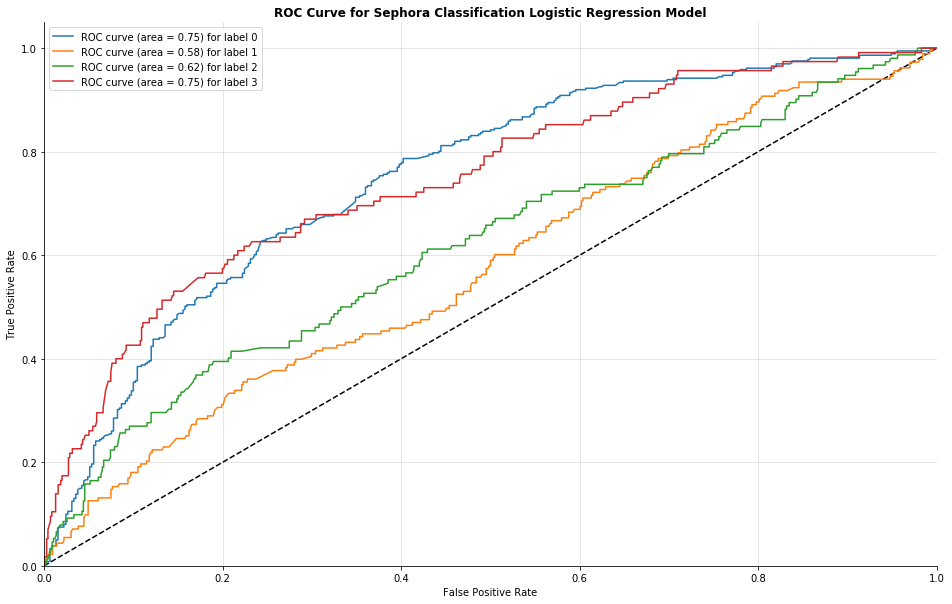

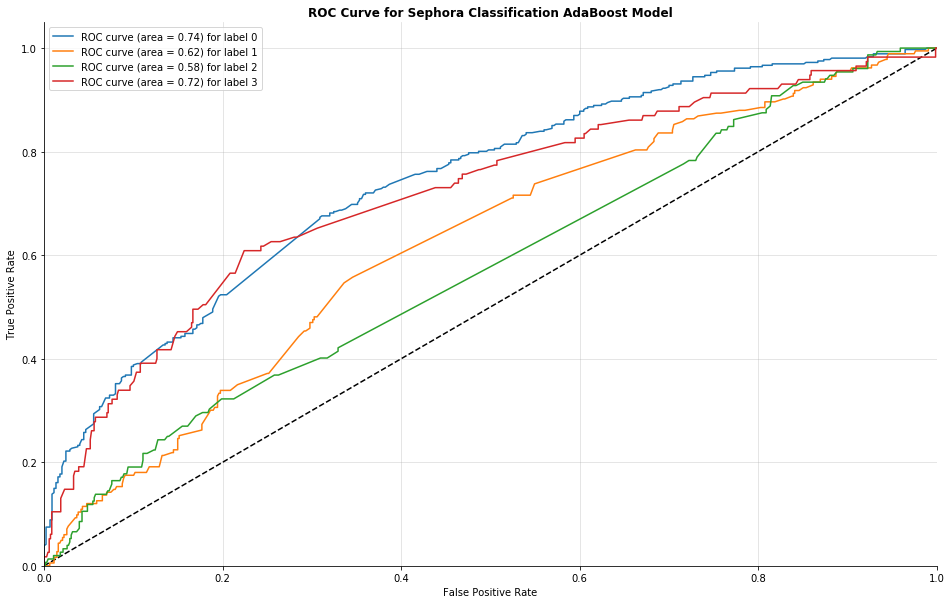

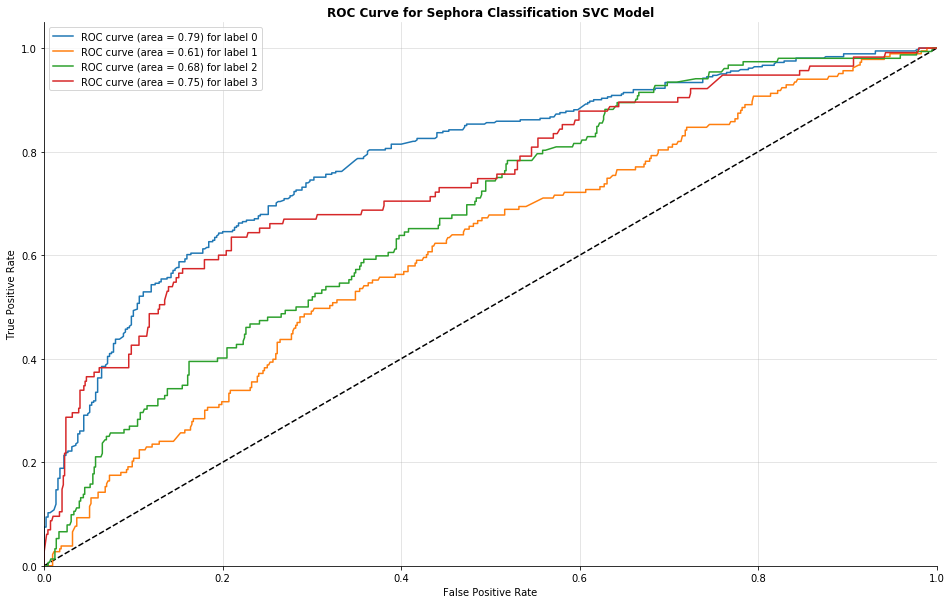

,Train f1_score,Test f1_score,Train Accuracy,Test Accuracy
Logistic Regression,0.877862,0.493897,0.879101,0.49815
KNN,0.516008,0.36081,0.543135,0.38471
Decision Tree,0.876861,0.456682,0.879101,0.462392
Bagging,0.858857,0.484061,0.859052,0.504316
Random Forest,0.863082,0.463972,0.863913,0.491985
AdaBoost,0.545089,0.447762,0.576549,0.490752
SVC,0.771275,0.45593,0.780073,0.508015
Multinomial NB,0.774753,0.508783,0.77825,0.516646


In [9]:
#instantiating the models
logreg = LogisticRegression(solver = 'lbfgs', penalty = 'none', multi_class = 'multinomial', max_iter = 1000)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
bdt = BaggingClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=10)
ada = AdaBoostClassifier()
svc = SVC(gamma = 'scale')
nb = MultinomialNB()


#dictionary of model names and their instantiated name
models = {
    'Logistic Regression': logreg,
    'KNN': knn, 
    'Decision Tree': dt, 
    'Bagging': bdt, 
    'Random Forest': rf, 
    'AdaBoost': ada,
    'SVC': svc,
    'Multinomial NB':nb
}
#list of model names
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Bagging', 'Random Forest', 'AdaBoost', 'SVC', 'Multinomial NB']
#creating a data frame that rmse scores will go in to
f1_all = pd.DataFrame(index = model_names, columns = ['Train f1_score', 'Test f1_score', 'Train Accuracy', 'Test Accuracy'])
#fitting the models and calculating their rmse
for x in models:
    models[x].fit(X_train_cvec, y_train) #fitting the model
    y_train_preds = models[x].predict(X_train_cvec) #prediction for train
    y_test_preds = models[x].predict(X_test_cvec) #prediction for test
    f1_train = f1_score(y_train, y_train_preds, average = 'weighted')
    f1_test = f1_score(y_test, y_test_preds, average = 'weighted')
    #f1_train = 1
    #f1_test = 1
    f1_all.loc[x, 'Train f1_score'] = f1_train #updating the dataframe
    f1_all.loc[x, 'Test f1_score'] = f1_test
    f1_all.loc[x, 'Train Accuracy'] = models[x].score(X_train_cvec, y_train)
    f1_all.loc[x, 'Test Accuracy'] = models[x].score(X_test_cvec, y_test)
    
    #plotting ROC curves
    try:
        clf = OneVsRestClassifier(models[x])
        clf.fit(X_train_cvec, y_train)
        plot_multiclass_roc(clf, X_test_cvec, y_test, x, n_classes=4, figsize=(16, 10))
    except:
        pass
    
    
f1_all

## Brand and Category

In [13]:
X = products[['brand', 'category']] #setting our X variable

y = products['class'] #our y variable is price_per_ounce

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33, stratify = y)

In [14]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [15]:
logreg = LogisticRegression(solver = 'lbfgs', penalty = 'none', multi_class = 'multinomial', max_iter = 1000)
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train)

0.7332928311057109

In [16]:
logreg.score(X_test, y_test)

0.6350184956843403

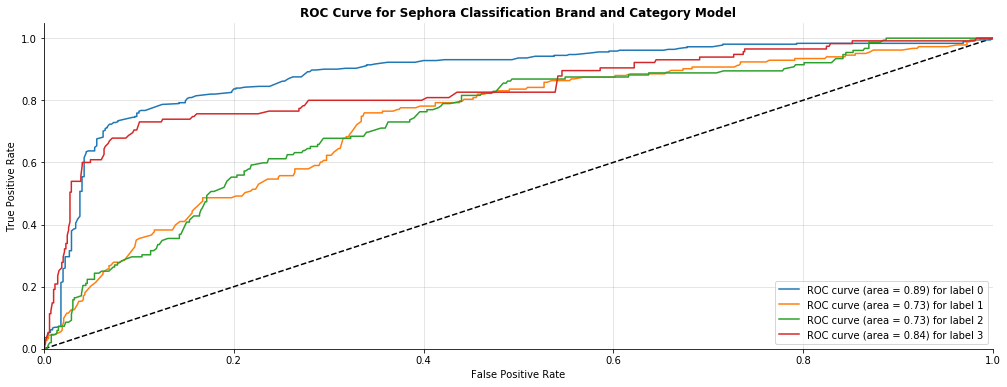

In [17]:
clf = OneVsRestClassifier(logreg)
clf.fit(X_train, y_train)
plot_multiclass_roc(clf, X_test, y_test, 'Brand and Category', 4)

## Brand, Category and Ingredients

In [18]:
X = products[['brand', 'category', 'ingredients']] #setting our X variable

y = products['class'] #our y variable is price_per_ounce

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,  test_size=.33, stratify = y)

In [19]:
#Will Sutton code
class Columns():
    def __init__(self):
        pass
    def fit(self, X, y): return self
    def transform(self, x):
        return x.iloc[:,2]

In [20]:
pipe1 = make_pipeline(Columns(),
                      CountVectorizer(tokenizer=lambda x: x.split(', ')),
                      MultinomialNB(alpha = 0.919191, fit_prior = True))
pipe2 = make_pipeline(ColumnSelector(cols =(0,1)),
                      OneHotEncoder(handle_unknown = 'ignore'),
                      LogisticRegression(solver = 'lbfgs', penalty = 'none', multi_class = 'multinomial', max_iter = 1000))

eclf = EnsembleVoteClassifier(clfs = [pipe1, pipe2])
eclf.fit(X_train, y_train);

In [21]:
eclf.score(X_train, y_train)

0.7436208991494532

In [22]:
eclf.score(X_test, y_test)

0.5881627620221949